# March Madness Model
How likely is a team to make the Final Four of the NCAA Tournament?

# Introduction

Each year, close to $4 billion is wagered on the NCAA Division 1 men's basketball tournament. Most of that money is wagered where the objective is to correctly predict winners of each game, with emphasis on the last four teams remaining (the Final Four). 

In this project, my motivation is the following:

Based on a college's regular season performance and seeding information, can I predict whether or not they will reach the final four? 

What are the variables that are correlated to predicting teams that make it to the final four? As a corollary, my model will also output the associated probabilities of making it to the final 4. Am I able to outperform a naive model? As even the sport pundits will tell you, since 2008, 53% of the time, at least 2 No. 1 seeds make the final four. So just by choosing two No 1. seeds, you're half way there.


As a trusted advisor to Coach Krzyzewski (Duke) or Coach Izzo (Michigan State), how would I recommend spending time developing the team? 

Or at the very least, how do I improve my 2020 bracket to make some money?

# Preprocessing

## Import libraries

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# plotting 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# preprocessing & feature engineering
from sklearn.preprocessing import StandardScaler, LabelBinarizer, PolynomialFeatures
from sklearn_pandas import DataFrameMapper, CategoricalImputer, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

# modelling & evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix
# scientific notation off
np.set_printoptions(suppress=True)
# pd.options.display.float_format = '{:.2f}'.format

# suppress warnings
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

## Data

The data spans 2003 to 2017 and is compiled from [sports-reference.com](https://www.sports-reference.com/cbb/schools/virginia/2019-gamelogs.html). 

The data is spread across four files:

- `regular_season.csv` - gamelogs for every regular season game
- `teams.csv` - team_id, names, and conferences
- `march_madness.csv` - gamelogs for each NCAA tournament game
- `march_madness_seeds.csv` - entry seeds for each team (W, X, Y, Z indicate the region)

### Understand the data

In [3]:
regular = pd.read_csv("./data/ncaa_data/regular_season.csv")
regular.tail()
# regular.groupby("season").max()

,season,day_in_season,winning_team_id,winning_team_score,losing_team_id,losing_team_score,winning_team_field_goals,winning_team_field_goals_attempted,winning_team_three_points,winning_team_three_points_attempted,...,losing_team_three_points_attempted,losing_team_free_throws,losing_team_free_throws_attempted,losing_team_offensive_rebounds,losing_team_defensive_rebounds,losing_team_assists,losing_team_turnovers,losing_team_steals,losing_team_blocks,losing_team_personal_fouls
76631,2017,132,1276,71,1458,56,27,48,10,23,...,15,6,8,14,18,10,15,4,3,13
76632,2017,132,1343,71,1463,59,25,52,11,26,...,20,13,19,14,20,12,7,4,5,13
76633,2017,132,1348,70,1433,63,24,54,8,20,...,14,17,22,23,24,8,5,4,1,16
76634,2017,132,1374,71,1153,56,26,52,10,19,...,24,14,18,17,22,7,7,7,1,13
76635,2017,132,1407,59,1402,53,21,60,1,17,...,17,7,8,9,27,10,17,1,7,18


Let's understand the last row. 
1407 = Troy, 1402 = Texas State.
Troy beat Texas State 59 to 53 on 132 day in season which is Sunday, March 2017 Troy. (Technically, 2016 - 2017 Season). Notice that ll games finish on day 132 in each year.

In [3]:
# regular.info()
# regular.describe()

* 32 variables
* games from 2003 to 2017
* stats per each team, team id
* no null values, all ints
* 2018 is left out in this data set

In [4]:
teams = pd.read_csv("./data/ncaa_data/teams.csv")
teams.head()

,season,team_id,team_name,conference_code,conference_name
0,2014,1101,Abilene Chr,southland,Southland Conference
1,2015,1101,Abilene Chr,southland,Southland Conference
2,2016,1101,Abilene Chr,southland,Southland Conference
3,2017,1101,Abilene Chr,southland,Southland Conference
4,2018,1101,Abilene Chr,southland,Southland Conference


In [6]:
# teams.info()
# teams.describe()
teams = teams.drop(columns=["conference_name"])

* use to join team name, conference code to easily interpret
* drop conference name, it's redundant
* conference info from 2003 to 2018
* no null values, int and object looks good

In [5]:
mm = pd.read_csv("./data/ncaa_data/march_madness.csv")
mm.head()

,season,day_in_season,winning_team_id,winning_team_score,losing_team_id,losing_team_score
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38


In [8]:
# mm.info()
# mm.describe()

* 1985 to 2017 data about game logs for NCAA tournament
* scores, winning team & losing team 
* use 1985 -> 2017 data to predict 2018
* day 134, 135 are for first four, associated with 'a', 'b' seeds, they play to finalize seeding for final 64
* e.g. 11 Wake Forest 88, 11 Kansas State 95
* first day of round of 64 is 136
* last game is 154, which is the national champion
* e.g. UNC beat Gonzaga on Day 154 in 2017
* Let's drop 1985->2002 data, since I don't have regular season, seed or conference information for those years.

In [9]:
mm = mm[mm["season"]>=2003]

In [7]:
seeds = pd.read_csv("./data/ncaa_data/march_madness_seeds.csv")
seeds.head()

,season,seed,team_id
0,2003,W01,1328
1,2003,W02,1448
2,2003,W03,1393
3,2003,W04,1257
4,2003,W05,1280


In [11]:
# seeds.info()
# seeds.describe()

* seed information from 2003 to 2018
* there are 68 seeds
* Starting in 2011, NCAA tournament starts with 68 teams (e.g. 68 seeds), then dwindles down to 64.
* 8 lowest seeded teams play in the ‘first four’, and then the winners, come out to be apart of the 64.
* merge to use seed as a variable, join on team_id
* seed needs to be an int; let's remove the region, it doesn't really matter, what we care about are the raw seeds, treat Y16a and Y16b as 16

In [8]:
seeds["seed"] = seeds["seed"].apply(lambda x: int(x[1:3]))

In [25]:
seed_and_names = pd.merge(seeds, teams, how="left", on=["season","team_id"]).drop_duplicates()
# 996 unique teams
seed_and_names.head()

,season,seed,team_id,team_name,conference_code,conference_name
0,2003,1,1328,Oklahoma,big_twelve,Big 12 Conference
22,2003,2,1448,Wake Forest,acc,Atlantic Coast Conference
56,2003,3,1393,Syracuse,big_east,Big East Conference
85,2003,4,1257,Louisville,cusa,Conference USA
95,2003,5,1280,Mississippi St,sec,Southeastern Conference


In [11]:
# print(teams[teams["team_name"]=="Gonzaga"]["team_id"].drop_duplicates()) #1211
# print(teams[teams["team_name"]=="South Carolina"]["team_id"].drop_duplicates()) #1376
# print(teams[teams["team_name"]=="Oregon"]["team_id"].drop_duplicates()) #1332
# print(teams[teams["team_name"]=="North Carolina"]["team_id"].drop_duplicates()) #1314

* I need a label to indicate if the team is in the final 4
* e.g. in 2017, final four were Gonzaga, South Carolina, Oregon and North Carolina
* 1211, 1376, 1322, 1314 respectively
* So, we can see that on day 154, the national championship game was played, and the winner was North Carolina
* Moreover, the final four teams are North Carolina vs Oregon, and Gonzaga vs South Carolina
* These correspond to games played on 152

In [14]:
mm[mm["season"]==2017].tail()

,season,day_in_season,winning_team_id,winning_team_score,losing_team_id,losing_team_score
2112,2017,146,1314,75,1246,73
2113,2017,146,1376,77,1196,70
2114,2017,152,1211,77,1376,73
2115,2017,152,1314,77,1332,76
2116,2017,154,1314,71,1211,65


In [15]:
# Let's check this for 2016 as well
mm[mm["season"]==2016].tail()

,season,day_in_season,winning_team_id,winning_team_score,losing_team_id,losing_team_score
2045,2016,146,1314,88,1323,74
2046,2016,146,1393,68,1438,62
2047,2016,152,1314,83,1393,66
2048,2016,152,1437,95,1328,51
2049,2016,154,1437,77,1314,74


* Villanova 1437 vs Oklahoma 1328 
* North Carolina 1314 vs Syracuse 1393
* Villanova won it all in 2016

We can see the championship game was also played on 154, final four played on 152! 
Perfect, now we can flag all of these teams as final four = 1

In [10]:
# 15 seasons, we should get 2*15 = 30 final four games
mm["final_four"]=mm["day_in_season"].apply(lambda x: 1 if x == 152 else 0)

# we'll can query the winning_team_id and losing_team_id for each of those games to get the final four teams
mm.tail()

,season,day_in_season,winning_team_id,winning_team_score,losing_team_id,losing_team_score,final_four
2112,2017,146,1314,75,1246,73,0
2113,2017,146,1376,77,1196,70,0
2114,2017,152,1211,77,1376,73,1
2115,2017,152,1314,77,1332,76,1
2116,2017,154,1314,71,1211,65,0


## Define X and y

Let's define X and y so we can more easily perform EDA, feature engineering and modelling.
First, we'll need a target vector y, with all the teams in each season and whether or not
they made it to the Final Four.

Let's work off the seeds_and_names data frame, as those are all of our 996 participating colleges for each season.

In [27]:
def is_final_four(team_id, season):
    '''This function checks if a team played in a Final Four game
    is_final_four(1242,2003) >>> 1
    is_final_four(1328,2003) >> 0'''

    # all the final 4 games
    final_four = mm.query('final_four == 1')
    
    # check if the team in a particular season played in a final four game
    if (team_id in list(final_four[final_four["season"]==season].winning_team_id)
        or team_id in list(final_four[final_four["season"]==season].losing_team_id)):
        return 1
    else:
        return 0

In [12]:
%%time 
seed_and_names["final_four"] = (seed_and_names[["team_id","season"]].
                                apply(lambda seed_and_names: 
                                      is_final_four(seed_and_names["team_id"],
                                                    seed_and_names["season"]),axis=1))

seed_and_names.head()

CPU times: user 3.56 s, sys: 139 ms, total: 3.7 s
Wall time: 3.7 s


In [19]:
# check
seed_and_names.query("final_four==1 & season==2017")

,season,seed,team_id,team_name,conference_code,final_four
23045,2017,7,1376,South Carolina,sec,1
23292,2017,1,1211,Gonzaga,wcc,1
23604,2017,3,1332,Oregon,pac_twelve,1
23905,2017,1,1314,North Carolina,acc,1


Great, now we have a final_four which will be our target y. Now we have to aggregate the stats for each
team, over all the 76636 games played.

e.g. for South Carolina, we now need the following aggregated stats for, points for, points against, etc.
Aggregating opponents stats so we have a sense of offensive and defensive ability because
defense wins champions!

In [20]:
print(list(regular.columns)[3])
list(regular.columns)[6:19]

winning_team_score


['winning_team_field_goals',
 'winning_team_field_goals_attempted',
 'winning_team_three_points',
 'winning_team_three_points_attempted',
 'winning_team_free_throws',
 'winning_team_free_throws_attempted',
 'winning_team_offensive_rebounds',
 'winning_team_defensive_rebounds',
 'winning_team_assists',
 'winning_team_turnovers',
 'winning_team_steals',
 'winning_team_blocks',
 'winning_team_personal_fouls']

In [108]:
# for each time a a specific team won, sum up all of their points
# for each time a specific team lose, sum of all of their points
# sum up points from won and lost games

# let's use team 1102 (Airforce)
regular.groupby(["season","winning_team_id"]).sum().query("winning_team_id==1102 & season==2003")["winning_team_score"][0]

825

In [107]:
regular.groupby(["season","losing_team_id"]).sum().query("losing_team_id==1102 & season==2003")["losing_team_score"][0]

778

In [ ]:
# add up both; team 1102 scored 1603 points scored in 2003.
# Let's check this with sports reference, and this is right!

In [112]:
# also find out the points allowed by Airforce when they win
regular.groupby(["season","winning_team_id"]).sum().query("winning_team_id==1102 & season==2003")["losing_team_score"][0]

,,day_in_season,winning_team_score,losing_team_id,losing_team_score,winning_team_field_goals,winning_team_field_goals_attempted,winning_team_three_points,winning_team_three_points_attempted,winning_team_free_throws,winning_team_free_throws_attempted,...,losing_team_three_points_attempted,losing_team_free_throws,losing_team_free_throws_attempted,losing_team_offensive_rebounds,losing_team_defensive_rebounds,losing_team_assists,losing_team_turnovers,losing_team_steals,losing_team_blocks,losing_team_personal_fouls
season,winning_team_id,,,,,,,,,,,,,,,,,,,,,
2003,1102,694,825,15438,638,271,480,120,259,163,249,...,170,125,174,127,216,92,170,71,11,243


In [114]:
# also find out the points allowed by Airforce when they lose
regular.groupby(["season","losing_team_id"]).sum().query("losing_team_id==1102 & season==2003")["winning_team_score"][0]
# points allowed total 1596

958

In [115]:
# Let's write a function to automate this for any team and season
# Note, ran into error with Wichita St. since they were undefeated, 
# need to add try except clause, to avoid indexing issues

def points_for(team_id, season):
    '''This function generates the team's total points scored in a season.
    points_for(1102,2003) >>> 1603'''
    # points from winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}').values[0][1]
    except:
        i = 0
    # points from losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}').values[0][3]
    except:
        j = 0
    return i+j

def points_against(team_id,season):
    '''This function generates the team's points against in a season.
    points_against(1102,2003) >> 1596'''
    # points allowed from winning games
    try:
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}').values[0][3]
    except:
        i = 0
    # points allowed from losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}').values[0][2]
    except:
        j = 0
    return i+j

In [ ]:
# points_for(1102,2003)
# points_against(1102,2003)

In [ ]:
# points_against(1455,2014)
# regular.groupby(["season","losing_team_id"]).sum().query("losing_team_id==1455 & season==2014")["winning_team_score"]
# debug = seed_and_names.reset_index()
# debug[debug["index"]==19244] 

In [116]:
# function works, but is slow. Max, how do I refactor this? 
# A little janky, but let's get this working to focus on modelling
# It's only 1000 rows, but I guess it's doing a lot of work to sum up
# Would iterrows be more performant? I'm not convinced. I need a vectorized solution.
seed_and_names["points_for"] = (seed_and_names[["team_id","season"]].
                                apply(lambda seed_and_names: 
                                      points_for(seed_and_names["team_id"],
                                                    seed_and_names["season"]),axis=1))

seed_and_names["points_against"] = (seed_and_names[["team_id","season"]].
                                    apply(lambda seed_and_names: 
                                          points_against(seed_and_names["team_id"],
                                                         seed_and_names["season"]),axis=1))

Now that we have a formula, let's repeat this for all the other columns.

In [28]:
def fg_for(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["winning_team_field_goals"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["losing_team_field_goals"][0]
    except:
        j = 0
    return i+j

def fg_against(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["losing_team_field_goals"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["winning_team_field_goals"][0]
    except:
        j = 0
    return i+j


def fga_for(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["winning_team_field_goals_attempted"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["losing_team_field_goals_attempted"][0]
    except:
        j = 0
    return i+j

def fga_against(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["losing_team_field_goals_attempted"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["winning_team_field_goals_attempted"][0]
    except:
        j = 0
    return i+j



seed_and_names["fg_for"] = (seed_and_names[["team_id","season"]].
                                apply(lambda seed_and_names: 
                                      fg_for(seed_and_names["team_id"],
                                                    seed_and_names["season"]),axis=1))

seed_and_names["fg_against"] = (seed_and_names[["team_id","season"]].
                                    apply(lambda seed_and_names: 
                                          fg_against(seed_and_names["team_id"],
                                                         seed_and_names["season"]),axis=1))


seed_and_names["fga_for"] = (seed_and_names[["team_id","season"]].
                                apply(lambda seed_and_names: 
                                      fga_for(seed_and_names["team_id"],
                                                    seed_and_names["season"]),axis=1))

seed_and_names["fga_against"] = (seed_and_names[["team_id","season"]].
                                    apply(lambda seed_and_names: 
                                          fga_against(seed_and_names["team_id"],
                                                         seed_and_names["season"]),axis=1))

In [130]:
def threes_for(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["winning_team_three_points"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["losing_team_three_points"][0]
    except:
        j = 0
    return i+j

def threes_against(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["losing_team_three_points"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["winning_team_three_points"][0]
    except:
        j = 0
    return i+j

def threes_a_for(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["winning_team_three_points_attempted"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["losing_team_three_points_attempted"][0]
    except:
        j = 0
    return i+j

def threes_a_against(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["losing_team_three_points_attempted"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["winning_team_three_points__attempted"][0]
    except:
        j = 0
    return i+j


seed_and_names["3pm_for"] = (seed_and_names[["team_id","season"]].
                                apply(lambda seed_and_names: 
                                      threes_for(seed_and_names["team_id"],
                                                    seed_and_names["season"]),axis=1))

seed_and_names["3pm_against"] = (seed_and_names[["team_id","season"]].
                                    apply(lambda seed_and_names: 
                                          threes_against(seed_and_names["team_id"],
                                                         seed_and_names["season"]),axis=1))


seed_and_names["3pa_for"] = (seed_and_names[["team_id","season"]].
                                apply(lambda seed_and_names: 
                                      threes_a_for(seed_and_names["team_id"],
                                                    seed_and_names["season"]),axis=1))

seed_and_names["3pa_against"] = (seed_and_names[["team_id","season"]].
                                    apply(lambda seed_and_names: 
                                          threes_a_against(seed_and_names["team_id"],
                                                         seed_and_names["season"]),axis=1))

In [119]:
def ft_for(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["winning_team_free_throws"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["losing_team_free_throws"][0]
    except:
        j = 0
    return i+j

def ft_against(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["losing_team_free_throws"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["winning_team_free_throws"][0]
    except:
        j = 0
    return i+j

def fta_for(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["winning_team_free_throws_attempted"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["losing_team_free_throws_attempted"][0]
    except:
        j = 0
    return i+j

def fta_against(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["losing_team_free_throws_attempted"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["winning_team_free_throws_attempted"][0]
    except:
        j = 0
    return i+j



seed_and_names["ft_for"] = (seed_and_names[["team_id","season"]].
                                apply(lambda seed_and_names: 
                                      ft_for(seed_and_names["team_id"],
                                                    seed_and_names["season"]),axis=1))

seed_and_names["ft_against"] = (seed_and_names[["team_id","season"]].
                                    apply(lambda seed_and_names: 
                                          ft_against(seed_and_names["team_id"],
                                                         seed_and_names["season"]),axis=1))



seed_and_names["fta_for"] = (seed_and_names[["team_id","season"]].
                                apply(lambda seed_and_names: 
                                      fta_for(seed_and_names["team_id"],
                                                    seed_and_names["season"]),axis=1))

seed_and_names["fta_against"] = (seed_and_names[["team_id","season"]].
                                    apply(lambda seed_and_names: 
                                          fta_against(seed_and_names["team_id"],
                                                         seed_and_names["season"]),axis=1))

In [120]:
def offensive_rebounds_for(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["winning_team_offensive_rebounds"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["losing_team_offensive_rebounds"][0]
    except:
        j = 0
    return i+j

def offensive_rebounds_against(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["losing_team_offensive_rebounds"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["winning_team_offensive_rebounds"][0]
    except:
        j = 0
    return i+j

def defensive_rebounds_for(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["winning_team_defensive_rebounds"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["losing_team_defensive_rebounds"][0]
    except:
        j = 0
    return i+j

def defensive_rebounds_against(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["losing_team_defensive_rebounds"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["winning_team_defensive_rebounds"][0]
    except:
        j = 0
    return i+j


seed_and_names["off_rebounds_for"] = (seed_and_names[["team_id","season"]].
                                      apply(lambda seed_and_names: 
                                      offensive_rebounds_for(seed_and_names["team_id"],
                                                             seed_and_names["season"]),axis=1))

seed_and_names["off_rebounds_against"] = (seed_and_names[["team_id","season"]].
                                          apply(lambda seed_and_names: 
                                          offensive_rebounds_against(seed_and_names["team_id"],
                                                                     seed_and_names["season"]),axis=1))


seed_and_names["def_rebounds_for"] = (seed_and_names[["team_id","season"]].
                                      apply(lambda seed_and_names: 
                                            defensive_rebounds_for(seed_and_names["team_id"],
                                                                   seed_and_names["season"]),axis=1))

seed_and_names["def_rebounds_against"] = (seed_and_names[["team_id","season"]].
                                          apply(lambda seed_and_names: 
                                                defensive_rebounds_against(seed_and_names["team_id"],
                                                                           seed_and_names["season"]),axis=1))

In [121]:
def assists_for(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["winning_team_assists"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["losing_team_assists"][0]
    except:
        j = 0
    return i+j

def assists_against(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["losing_team_assists"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["winning_team_assists"][0]
    except:
        j = 0
    return i+j


seed_and_names["assists_for"] = (seed_and_names[["team_id","season"]].
                                      apply(lambda seed_and_names: 
                                      assists_for(seed_and_names["team_id"],
                                                             seed_and_names["season"]),axis=1))

seed_and_names["assists_against"] = (seed_and_names[["team_id","season"]].
                                          apply(lambda seed_and_names: 
                                          assists_against(seed_and_names["team_id"],
                                                                     seed_and_names["season"]),axis=1))

In [123]:
def steals_for(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["winning_team_steals"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["losing_team_steals"][0]
    except:
        j = 0
    return i+j

def steals_against(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["losing_team_steals"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["winning_team_steals"][0]
    except:
        j = 0
    return i+j

def blocks_for(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["winning_team_blocks"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["losing_team_blocks"][0]
    except:
        j = 0
    return i+j

def blocks_against(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["losing_team_blocks"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["winning_team_blocks"][0]
    except:
        j = 0
    return i+j


seed_and_names["steals_for"] = (seed_and_names[["team_id","season"]].
                                      apply(lambda seed_and_names: 
                                      steals_for(seed_and_names["team_id"],
                                                             seed_and_names["season"]),axis=1))

seed_and_names["steals_against"] = (seed_and_names[["team_id","season"]].
                                          apply(lambda seed_and_names: 
                                          steals_against(seed_and_names["team_id"],
                                                                     seed_and_names["season"]),axis=1))


seed_and_names["blocks_for"] = (seed_and_names[["team_id","season"]].
                                      apply(lambda seed_and_names: 
                                            blocks_for(seed_and_names["team_id"],
                                                                   seed_and_names["season"]),axis=1))

seed_and_names["blocks_against"] = (seed_and_names[["team_id","season"]].
                                          apply(lambda seed_and_names: 
                                                blocks_against(seed_and_names["team_id"],
                                                               seed_and_names["season"]),axis=1))

In [124]:
def turnovers_for(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["winning_team_turnovers"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["losing_team_turnovers"][0]
    except:
        j = 0
    return i+j

def turnovers_against(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["losing_team_turnovers"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["winning_team_turnovers"][0]
    except:
        j = 0
    return i+j

def fouls_for(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["winning_team_personal_fouls"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["losing_team_personal_fouls"][0]
    except:
        j = 0
    return i+j

def fouls_against(team_id, season):
    #winning games
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["losing_team_personal_fouls"][0]
    except:
        i = 0
    #losing games
    try:
        j = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["winning_team_personal_fouls"][0]
    except:
        j = 0
    return i+j


seed_and_names["turnovers_for"] = (seed_and_names[["team_id","season"]].
                                      apply(lambda seed_and_names: 
                                      turnovers_for(seed_and_names["team_id"],
                                                             seed_and_names["season"]),axis=1))

seed_and_names["turnovers_against"] = (seed_and_names[["team_id","season"]].
                                          apply(lambda seed_and_names: 
                                          turnovers_against(seed_and_names["team_id"],
                                                                     seed_and_names["season"]),axis=1))


seed_and_names["fouls_for"] = (seed_and_names[["team_id","season"]].
                                      apply(lambda seed_and_names: 
                                            fouls_for(seed_and_names["team_id"],
                                                                   seed_and_names["season"]),axis=1))

seed_and_names["fouls_against"] = (seed_and_names[["team_id","season"]].
                                          apply(lambda seed_and_names: 
                                                fouls_against(seed_and_names["team_id"],
                                                               seed_and_names["season"]),axis=1))

In [141]:
regular_season_total = seed_and_names.reset_index().drop(columns=["index"])

In [143]:
regular_season_total.columns

Index(['season', 'seed', 'team_id', 'team_name', 'conference_code',
       'final_four', 'points_for', 'points_against', 'fg_for', 'fg_against',
       'fga_for', 'fga_against', '3pm_for', '3pm_against', '3pa_for',
       '3pa_against', 'ft_for', 'ft_against', 'fta_for', 'fta_against',
       'off_rebounds_for', 'off_rebounds_against', 'def_rebounds_for',
       'def_rebounds_against', 'assists_for', 'assists_against', 'steals_for',
       'steals_against', 'blocks_for', 'blocks_against', 'turnovers_for',
       'turnovers_against', 'fouls_for', 'fouls_against'],
      dtype='object')

## Train Test Split


* As always, let's train test split (80% / 20%). Given it's time series we can split on years.
* There are 15 years of data, so we'll train on 12 years and test on the final 3 years (2015, 2016, 2017)

In [195]:
y_test = regular_season_total[regular_season_total["season"]>=2015]["final_four"]
y_train = regular_season_total[regular_season_total["season"]<2015]["final_four"]

In [196]:
X = regular_season_total[['season', 'seed', 'team_id', 'team_name', 'conference_code',
                           'points_for', 'points_against', 'fg_for', 'fg_against',
                           '3pm_for', '3pm_against', 'fga_for', 'fga_against', '3pa_for',
                           '3pa_against', 'ft_for', 'ft_against', 'fta_for', 'fta_against',
                           'off_rebounds_for', 'off_rebounds_against', 'def_rebounds_for',
                           'def_rebounds_against', 'assists_for', 'assists_against', 'steals_for',
                           'steals_against', 'blocks_for', 'blocks_against', 'turnovers_for',
                           'turnovers_against', 'fouls_for', 'fouls_against']]

In [197]:
X_train = X.query("season<2015")
X_test = X.query("season>=2015")

## Imputation
* Data is pretty complete and in the right type which is great. We'll just need to create multi class labels, such that we can identify which conferences a team is in, as I suspect that some teams play in more competitive conferences than others.
* Let's label qualitative variables.
* We'll standardize after splitting.

In [198]:
mapper = DataFrameMapper([
    (['season'],None),
    (['seed'],None),
    (['team_id'],None),
    (['conference_code'],LabelBinarizer()),    
    (['points_for'],None),
    (['points_against'],None),
    (['fg_for'],None),
    (['fg_against'],None),
    (['3pm_for'],None), 
    (['3pm_against'],None), 
    (['fga_for'],None),
    (['fga_against'],None),
    (['3pa_for'],None), 
    (['3pa_against'],None),
    (['ft_for'],None),  
    (['ft_against'],None),
    (['fta_for'],None),
    (['fta_against'],None),
    (['off_rebounds_for'],None),
    (['off_rebounds_against'],None),
    (['def_rebounds_for'],None),
    (['def_rebounds_against'],None),
    (['assists_for'],None),
    (['assists_against'],None),
    (['steals_for'],None),
    (['steals_against'],None),
    (['blocks_for'],None),
    (['blocks_against'],None),
    (['turnovers_for'],None),
    (['turnovers_against'],None),
    (['fouls_for'],None),
    (['fouls_against'],None)
],df_out=True)

In [199]:
Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test) # you never want to fit because if you see something you never saw before emoji
# then it will be 'labelbinarized', when it fact it should be treated as something diff instead

In [159]:
# problem
# list(zip(Z_train.columns,Z_test.columns)) # there are less conferences in 2015 -> 2018
# mid_cont, pac_ten are in Z_train but not in Z_test

In [200]:
teams[teams["conference_code"]=="mid_cont"].drop_duplicates(subset="season") # only occured 2004->2007
# Chicago moved from mid_cont to gwc in 2010

,season,team_id,team_name,conference_code
14628,2004,1147,Centenary,mid_cont
14629,2005,1147,Centenary,mid_cont
14630,2006,1147,Centenary,mid_cont
14631,2007,1147,Centenary,mid_cont
16279,2003,1152,Chicago St,mid_cont


In [201]:
teams[teams["conference_code"]=="pac_ten"].drop_duplicates(subset="season") # only occured 2003->2011;
# in 2012, Arizona played in pac_twelmanually add ve
# let's be more verbose and label mid_cont in pac_ten columns in test, with 0 so they're the same width

,season,team_id,team_name,conference_code
3601,2003,1112,Arizona,pac_ten
3602,2004,1112,Arizona,pac_ten
3603,2005,1112,Arizona,pac_ten
3604,2006,1112,Arizona,pac_ten
3605,2007,1112,Arizona,pac_ten
3606,2008,1112,Arizona,pac_ten
3607,2009,1112,Arizona,pac_ten
3608,2010,1112,Arizona,pac_ten
3609,2011,1112,Arizona,pac_ten


In [202]:
Z_test["conference_code_pac_ten"] = pd.DataFrame(np.zeros((Z_test.shape[0],1)))
Z_test["conference_code_mid_cont"] = pd.DataFrame(np.zeros((Z_test.shape[0],1)))

#Showing up as NaN -> need to make zero
Z_test["conference_code_pac_ten"].fillna(0,inplace=True)
Z_test["conference_code_mid_cont"].fillna(0,inplace=True)

## Establish Benchmarks
Let's quickly spin up a naive baseline/benchmark model & naive out the door. Then, in subsequent steps, we can feature engineering and model to improve our score!

From FiveThirtyEight, 1 seeds only had a 35%-52% of reaching the final four.

![ncaa](./images/ncaa.png)

reminder to add 538 image

Let's see how how our naive model's prediction fared.

In [203]:
# Baseline logistic 

# Step 1: Instantiate our model.
logreg_baseline = LogisticRegression(random_state=8)

# Step 2: Fit our model.
logreg_baseline.fit(Z_train,y_train)

# Step 3 (part 1): Generate prediction values
print(f'Number of teams making it to final four: {sum(logreg_baseline.predict(Z_train))}')

# Step 3 (part 2): Generate predictions/probabilities
logreg_baseline.predict_proba(Z_train)[:,1]

# Step 4: Score the model:
print(f' Logreg train accuracy: {logreg_baseline.score(Z_train,y_train)}')
print(f' Logreg test accuracy: {logreg_baseline.score(Z_test,y_test)}')

Number of teams making it to final four: 20
 Logreg train accuracy: 0.946969696969697
 Logreg test accuracy: 0.9656862745098039


### Imbalanced Classes

* Accuracy of 94% looks good right? However, we have imbalanced classes.
* Over 15 years, 60 final four teams, 936 non-final four, 996 total.
* 1-60/996 = 94%
* Any naive model would be equally as good as this baseline logistic regression, by simply taking the accuracy.
* This is a misleading accuracy as it's overestimated. Let's quickly spin up a AUC score to score the accuracy of this logistic classifier, and measure this imbalance.

In [240]:
roc_auc_score(y_test, logreg_baseline.predict_proba(Z_test)[:,1])

0.7777777777777778

See how the area under the curve score is close to 50%. With this model (trained on imbalanced classes), we are no better than a 'no information' classifer.

To get a better metric of our baseline model, let's better represent the minority class (final four)
with more signal, via SMOTE (Synthetic Minority Over-Sampling Technique).

In [205]:
# added final_four to this mapper so I can split after, preserve order rather than randomly splitting
mapper_all = DataFrameMapper([
    (['season'],None),
    (['seed'],None),
    (['team_id'],None),
    (['conference_code'],LabelBinarizer()),    
    (['final_four'],None),
    (['points_for'],None),
    (['points_against'],None),
    (['fg_for'],None),
    (['fg_against'],None),
    (['3pm_for'],None), 
    (['3pm_against'],None), 
    (['fga_for'],None),
    (['fga_against'],None),
    (['3pa_for'],None), 
    (['3pa_against'],None),
    (['ft_for'],None),  
    (['ft_against'],None),
    (['fta_for'],None),
    (['fta_against'],None),
    (['off_rebounds_for'],None),
    (['off_rebounds_against'],None),
    (['def_rebounds_for'],None),
    (['def_rebounds_against'],None),
    (['assists_for'],None),
    (['assists_against'],None),
    (['steals_for'],None),
    (['steals_against'],None),
    (['blocks_for'],None),
    (['blocks_against'],None),
    (['turnovers_for'],None),
    (['turnovers_against'],None),
    (['fouls_for'],None),
    (['fouls_against'],None)
],df_out=True)

In [229]:
Z = mapper_all.fit_transform(regular_season_total)
y = Z["final_four"]
X = Z[['season', 'seed', 'team_id', 'conference_code_a_sun',
       'conference_code_a_ten', 'conference_code_aac', 'conference_code_acc',
       'conference_code_aec', 'conference_code_big_east',
       'conference_code_big_sky', 'conference_code_big_south',
       'conference_code_big_ten', 'conference_code_big_twelve',
       'conference_code_big_west', 'conference_code_caa',
       'conference_code_cusa', 'conference_code_horizon',
       'conference_code_ivy', 'conference_code_maac', 'conference_code_mac',
       'conference_code_meac', 'conference_code_mid_cont',
       'conference_code_mvc', 'conference_code_mwc', 'conference_code_nec',
       'conference_code_ovc', 'conference_code_pac_ten',
       'conference_code_pac_twelve', 'conference_code_patriot',
       'conference_code_sec', 'conference_code_southern',
       'conference_code_southland', 'conference_code_summit',
       'conference_code_sun_belt', 'conference_code_swac',
       'conference_code_wac', 'conference_code_wcc',
       'points_for', 'points_against', 'fg_for', 'fg_against', '3pm_for',
       '3pm_against', 'fga_for', 'fga_against', '3pa_for', '3pa_against',
       'ft_for', 'ft_against', 'fta_for', 'fta_against', 'off_rebounds_for',
       'off_rebounds_against', 'def_rebounds_for', 'def_rebounds_against',
       'assists_for', 'assists_against', 'steals_for', 'steals_against',
       'blocks_for', 'blocks_against', 'turnovers_for', 'turnovers_against',
       'fouls_for', 'fouls_against']]

# instantiate SMOTE
smote = SMOTE(ratio='minority',random_state=8)
X_sm, y_sm = smote.fit_sample(X, y)
print(X_sm.shape) 
print(y_sm.shape) # there are 936 final four rows and 936 non-final four
print(sum(y_sm))

(1872, 65)
(1872,)
936


Let's recalculate accuracy and auc

In [252]:
df = pd.concat([pd.DataFrame(y_sm),pd.DataFrame(X_sm)],axis=1)
df.columns = ['final_four','season', 'seed', 'team_id', 'conference_code_a_sun',
       'conference_code_a_ten', 'conference_code_aac', 'conference_code_acc',
       'conference_code_aec', 'conference_code_big_east',
       'conference_code_big_sky', 'conference_code_big_south',
       'conference_code_big_ten', 'conference_code_big_twelve',
       'conference_code_big_west', 'conference_code_caa',
       'conference_code_cusa', 'conference_code_horizon',
       'conference_code_ivy', 'conference_code_maac', 'conference_code_mac',
       'conference_code_meac', 'conference_code_mid_cont',
       'conference_code_mvc', 'conference_code_mwc', 'conference_code_nec',
       'conference_code_ovc', 'conference_code_pac_ten',
       'conference_code_pac_twelve', 'conference_code_patriot',
       'conference_code_sec', 'conference_code_southern',
       'conference_code_southland', 'conference_code_summit',
       'conference_code_sun_belt', 'conference_code_swac',
       'conference_code_wac', 'conference_code_wcc', 'points_for',
       'points_against', 'fg_for', 'fg_against', '3pm_for', '3pm_against',
       'fga_for', 'fga_against', '3pa_for', '3pa_against', 'ft_for',
       'ft_against', 'fta_for', 'fta_against', 'off_rebounds_for',
       'off_rebounds_against', 'def_rebounds_for', 'def_rebounds_against',
       'assists_for', 'assists_against', 'steals_for', 'steals_against',
       'blocks_for', 'blocks_against', 'turnovers_for', 'turnovers_against',
       'fouls_for', 'fouls_against']

# Let's split on the years again
y_test = df[df["season"]>=2015]["final_four"]
y_train = df[df["season"]<2015]["final_four"]

# 269/1603 so about 17%/83% split which is fine, I prefer the interpretability and preserve meaning.
# We are using 2003 -> 2014 data to predict and test 2015, 2016, 2017.

In [257]:
X = df.loc[:,"season":"fouls_against"]
X_test = X[X["season"]>=2015]
X_train = X[X["season"]<2015]

In [258]:
print(X_train.shape)
print(y_train.shape)
print("\n")
print(X_test.shape)
print(y_test.shape)

(1603, 65)
(1603,)


(269, 65)
(269,)


In [259]:
# Baseline logistic 

# Step 1: Instantiate our model.
logreg_baseline = LogisticRegression(random_state=8)

# Step 2: Fit our model.
logreg_baseline.fit(X_train,y_train)

# Step 3 (part 1): Generate prediction values
print(f'Number of teams making it to final four: {sum(logreg_baseline.predict(X_train))}')

# Step 3 (part 2): Generate predictions/probabilities
logreg_baseline.predict_proba(X_train)[:,1]

# Step 4: Score the model:
print(f' Logreg train accuracy: {cross_val_score(logreg_baseline, X_train, y_train, cv=5).mean()}')
print(f' Logreg test accuracy: {cross_val_score(logreg_baseline, X_test, y_test, cv=5).mean()}')

Number of teams making it to final four: 837
 Logreg train accuracy: 0.9532202462914677
 Logreg test accuracy: 0.9221269296740996


In [260]:
roc_auc_score(y_test, logreg_baseline.predict_proba(X_test)[:,1])

0.9602949134199135

In [261]:
print(f' seed coeff {np.exp(-0.608454)}')
print(f' acc coeff {np.exp(-3.538678)}')

 seed coeff 0.5441915391886456
 acc coeff 0.029051708064839428


In [262]:
pd.DataFrame(list(zip(X.columns,logreg_baseline.coef_.T[:,0])))
# The seed is very important.
# Remember, need to take exponential. If your seed increases by 1, your likelihood of reaching final four
# is 0.54x less
# The individual team stats are less important, as I suspect the seed already captures a lot of that information.

# And what conference you play in matters (acc, big_twelve or big_ten)
# If you play in acc, your likelihood of reaching final four is 0.03x less, this is probably explaining
# for the teams who are not top tier.

,0,1
0,season,-0.001062
1,seed,-0.439209
2,team_id,-0.000361
3,conference_code_a_sun,-0.039266
4,conference_code_a_ten,-1.133449
5,conference_code_aac,-0.078609
6,conference_code_acc,-1.668645
7,conference_code_aec,-0.026041
8,conference_code_big_east,-1.204675
9,conference_code_big_sky,-0.012483


The AUC scores are more representative of the model's true performance. This basic logistic model was able to
be accurate 52% of the time with training data and 92% with test data. Therefore, it's a good benchmark, but
there is opportunity to improve the any over-fitting, and through feature engineering (advanced basketball metrics!)

Notice how the AUC score is much better now. With this model (trained on balanced classes), we are much better than a 'no information' classifier. In fact is very close to 1 so it does not display signals of imbalanced classes,
nor overwhelming amount of false positives vs false negatives. We'll revisit this later in model evaluation.

# Exploratory Data Analysis

Let us perform EDA to better understand our data. 

## Summary Statistics

### Correlation and Heatmap 

* Final_four is negatively correlated to seed (higher seed -> less likely to be in final four)
* Final_four is positively correlated to fg_for (higher fg_for -> more likely to be in final four)
    * Similar situation for blocks, assists, rebounds, points scored

* Some of these independent variables are highly correlated, so I may not want to use all of them to reduce over-fitting. 
    * For example, points_for is related with points against, so I may want to combine those in a points differential variable, and offensive efficiency will combine (assists_for, fg_for)

In [310]:
quant = df[['final_four', 'season', 'seed', 'team_id', 'points_for',
       'points_against', 'fg_for', 'fg_against', '3pm_for', '3pm_against',
       'fga_for', 'fga_against', '3pa_for', '3pa_against', 'ft_for',
       'ft_against', 'fta_for', 'fta_against', 'off_rebounds_for',
       'off_rebounds_against', 'def_rebounds_for', 'def_rebounds_against',
       'assists_for', 'assists_against', 'steals_for', 'steals_against',
       'blocks_for', 'blocks_against', 'turnovers_for', 'turnovers_against',
       'fouls_for', 'fouls_against']]

stats = df[['points_for','points_against', 'fg_for', 'fg_against', '3pm_for', '3pm_against',
       'fga_for', 'fga_against', '3pa_for', '3pa_against', 'ft_for',
       'ft_against', 'fta_for', 'fta_against', 'off_rebounds_for',
       'off_rebounds_against', 'def_rebounds_for', 'def_rebounds_against',
       'assists_for', 'assists_against', 'steals_for', 'steals_against',
       'blocks_for', 'blocks_against', 'turnovers_for', 'turnovers_against',
       'fouls_for', 'fouls_against']]

In [311]:
quant.corr()["final_four"]

final_four              1.000000
season                 -0.088572
seed                   -0.671353
team_id                -0.047393
points_for              0.420668
points_against          0.279562
fg_for                  0.436103
fg_against              0.299363
3pm_for                 0.132419
3pm_against             0.156121
fga_for                 0.395567
fga_against             0.374804
3pa_for                 0.136840
3pa_against             0.471266
ft_for                  0.292254
ft_against             -0.066517
fta_for                 0.290864
fta_against            -0.047742
off_rebounds_for        0.409847
off_rebounds_against    0.254282
def_rebounds_for        0.474183
def_rebounds_against    0.084649
assists_for             0.432095
assists_against         0.081193
steals_for              0.276889
steals_against          0.158755
blocks_for              0.366486
blocks_against          0.141490
turnovers_for           0.166151
turnovers_against       0.269311
fouls_for 

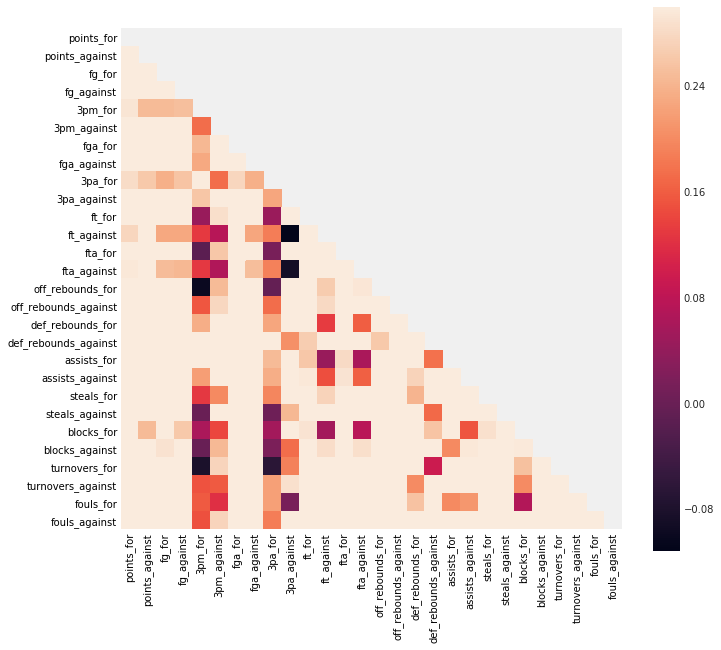

In [314]:
fig, ax = plt.subplots(figsize=(10, 10))
corr = stats.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, xticklabels = True, yticklabels = True)

In [ ]:
# stats.corr()

In [312]:
quant.describe()

,final_four,season,seed,team_id,points_for,points_against,fg_for,fg_against,3pm_for,3pm_against,...,assists_for,assists_against,steals_for,steals_against,blocks_for,blocks_against,turnovers_for,turnovers_against,fouls_for,fouls_against
count,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,...,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000
mean,0.491304,2009.733152,5.902717,1290.800000,0.082170,0.070945,0.028971,0.025257,6.917975,6.258598,...,15.264331,12.244795,7.338908,6.283238,4.388280,3.265049,13.204389,14.603750,18.038150,19.742397
std,0.500060,4.097770,4.799378,96.005048,0.018478,0.014926,0.006705,0.005426,1.307789,0.928820,...,2.119950,1.523999,1.476626,0.985864,1.502522,0.623705,1.836439,2.214709,2.020666,1.847527
min,0.000000,2003.000000,1.000000,1102.000000,0.051165,0.045878,0.017784,0.016117,2.689655,3.178571,...,9.354839,7.676471,3.451613,3.387097,0.655172,1.451613,7.387097,8.857143,12.029412,14.545455
25%,0.000000,2006.000000,2.000000,1211.750000,0.069122,0.060210,0.024268,0.021358,5.970588,5.633333,...,13.812500,11.170977,6.330882,5.616461,3.300000,2.812500,12.029412,13.090241,16.771822,18.468229
50%,0.000000,2010.000000,4.000000,1278.500000,0.077424,0.067318,0.027189,0.023993,6.875000,6.234314,...,15.200000,12.156250,7.183502,6.241379,4.107143,3.214286,13.190524,14.343750,18.062500,19.646110
75%,1.000000,2013.000000,10.000000,1373.250000,0.090343,0.078396,0.031852,0.027799,7.774194,6.838710,...,16.608583,13.176471,8.133333,6.900806,5.261111,3.645161,14.299808,15.831627,19.243534,20.847851
max,1.000000,2017.000000,16.000000,1463.000000,0.197555,0.155237,0.068938,0.055339,12.148148,10.468750,...,23.958333,17.625000,12.500000,11.041667,10.962963,5.793103,20.875000,23.708333,25.111111,27.916667


While the team's season statistics are useful, it may be more predictive to understand a team's performance on a per game basis, to understand how it's winning or losing its games.

The main categorical variable is conferences. It appears to also be predictive from the baseline, representing the strength of the conference. Some conferences are generally very strong and play stronger competition than others.
* big_ten (Michigan State, Purdue, Michigan)
* big_twelve (Texas Tech, Kansas State)
* acc (Duke, UNC, Virgnia)

In [313]:
(pd.DataFrame(regular_season_total.groupby("conference_code")["final_four"].sum()).
sort_values(by="final_four",ascending=False))[0:5]
# See that big_east, acc, big_ten, sec, big_twelve all have 5+ teams that have made it to the final four
# These are the conferences with the best teams

,final_four
conference_code,
big_east,11
acc,10
big_ten,10
sec,9
big_twelve,6


## Data Visualization

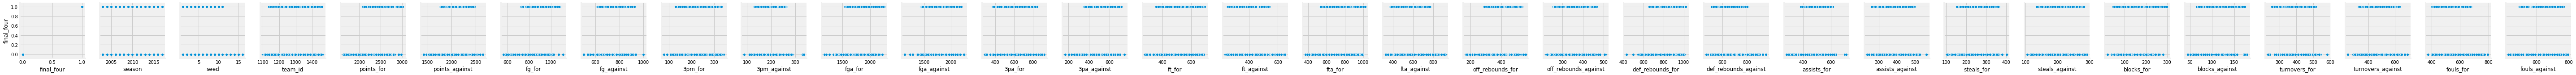

In [269]:
sns.pairplot(df, x_vars = list(quant.columns), y_vars = ["final_four"])

* Some observations include: 
    * No seeds greater than 11 have made it to final four
    * Teams which make the final four, in the regular season score more, make more FG, give up less FTs, rebound more, block more, foul less, ... all the attributes of a great basketball team

# Feature Engineering

## 'Standardize' features

Let's keep the stat metrics on the same scale, on a per game basis rather than standardizing to keep it interpretable. First we need to count the number of games for each team.

In [270]:
# add a column vector to indicate a game was played
regular["game_played"] = np.ones((regular.shape[0], 1))
regular.groupby(["season","winning_team_id"]).sum()
# sum over games where they won
# sum over games where they lost
# sum w + l = total games played

def games_won(team_id, season):
    try: 
        i = regular.groupby(["season","winning_team_id"]).sum().query(f'winning_team_id=={team_id} & season=={season}')["game_played"][0]
    except:
        i = 0
    return i
    
def games_lost(team_id,season):
    try:
        i = regular.groupby(["season","losing_team_id"]).sum().query(f'losing_team_id=={team_id} & season=={season}')["game_played"][0]
    except:
        i = 0
    return i


df["games_won"] = (df[["team_id","season"]].
                         apply(lambda df: 
                               games_won(df["team_id"],
                                         df["season"]),axis=1))

df["games_lost"] = (df[["team_id","season"]].
                             apply(lambda df: 
                                   games_lost(df["team_id"],
                                             df["season"]),axis=1))

In [271]:
df["games_total"] = df["games_won"] + df["games_lost"]

In [274]:
# Effective gf 
# This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal.
df["efg%"]=(df["fg_for"] + 0.5*df["3pm_for"]) / df["fga_for"]

In [279]:
# NTS: time permitting re-factor with FunctionTransformer
df["points_for"] = df["points_for"]/df["games_total"]
df["points_against"] = df["points_against"]/df["games_total"]
df['fg_for'] = df['fg_for']/df["games_total"]
df['fg_against'] = df['fg_against']/df["games_total"]
df['fga_for'] = df['fga_for']/df["games_total"]
df['fga_against'] = df['fga_against']/df["games_total"]
df['3pm_for'] = df['3pm_for']/df["games_total"]
df['3pm_against'] = df['3pm_against']/df["games_total"]
df['3pa_for'] = df['3pa_for']/df["games_total"]
df['3pa_against'] = df['3pa_against']/df["games_total"]
df['ft_for'] = df['ft_for']/df["games_total"]
df['ft_against'] = df['ft_against']/df["games_total"]
df['fta_for'] = df['fta_for']/df["games_total"]
df['fta_against'] = df['fta_against']/df["games_total"]
df['off_rebounds_for'] = df['off_rebounds_for']/df["games_total"]
df['off_rebounds_against'] = df['off_rebounds_against']/df["games_total"]
df['def_rebounds_for'] = df['def_rebounds_for']/df["games_total"]
df['def_rebounds_against'] = df['def_rebounds_against']/df["games_total"]
df['assists_for'] = df['assists_for']/df["games_total"]
df['assists_against'] = df['assists_against']/df["games_total"]
df['steals_for'] = df['steals_for']/df["games_total"]
df['steals_against'] = df['steals_against']/df["games_total"]
df['blocks_for'] = df['blocks_for']/df["games_total"]
df['blocks_against'] = df['blocks_against']/df["games_total"]
df['turnovers_for'] = df['turnovers_for']/df["games_total"]
df['turnovers_against'] = df['turnovers_against']/df["games_total"]
df['fouls_for'] = df['fouls_for']/df["games_total"]
df['fouls_against'] = df['fouls_against']/df["games_total"]

## Transform and add new features

Let's use some advanced metrics from the NBA. 
Note, opponent % are kept as to gauge defense as well.

In [281]:
# Now, instead of games_won and games_lost, let's combine this into win_%
df['win_%']=df["games_won"]/df["games_total"]

# +/- point differential aka margin of victory
df["margin_of_victory"]=df["points_for"]-df["points_against"]

# Assist to turnover ratio: this measures your ability to care of possessions and pass the ball, as a team.
df["ast_to_ratio"] = df["assists_for"]/df["turnovers_for"]

# Let's convert field goals, threes and fts into %. Will reduce collinearity and also simplify interpretation.
df['fg%_for'] = df['fg_for']/df['fga_for']
df['fg%_against'] = df['fg_against']/df['fga_against']

df['3p%_for'] = X['3pm_for']/X['3pa_for']
df['3p%_against'] = df['3pm_against']/df['3pa_against']

df['ft%_for'] = df['ft_for']/X['fta_for']
df['ft%_against'] = df['ft_against']/df['fta_against']

In [282]:
# drop games won, lost, its redundant with win_%
df = df.drop(["games_won","games_lost"],axis=1) 

In [288]:
# 33 games have no data, probably from SMOTE these teams don't exist. Let's just drop for now since I'm getting NaN.
# df[df["win_%"].isna()].index
df = df.drop([1036, 1049, 1134, 1150, 1158, 1187, 1216, 1299, 1310, 1341, 1353,
            1361, 1375, 1389, 1434, 1444, 1452, 1492, 1528, 1530, 1533, 1572,
            1624, 1643, 1653, 1711, 1720, 1749, 1760, 1783, 1850, 1851])

,final_four,season,seed,team_id,conference_code_a_sun,conference_code_a_ten,conference_code_aac,conference_code_acc,conference_code_aec,conference_code_big_east,...,efg%,win_%,margin_of_victory,ast_to_ratio,fg%_for,fg%_against,3p%_for,3p%_against,ft%_for,ft%_against


In [289]:
df.to_csv("./data/df.csv")
X.shape # 1840 observations

(1872, 65)

I will keep the original features and use regularization methods in the next section.

# Modelling
## Logistic Regression with Regularization
### L1: Lasso

I prefer Lasso as a shrinkage method, to narrow down on the most important features, since our baseline model was very accurate already. 

In [290]:
y_test = df[df["season"]>=2015]["final_four"]
y_train = df[df["season"]<2015]["final_four"]
X_train = df.query("season<2015").loc[:,"season":"ft%_against"]
X_test = df.query("season>=2015").loc[:,"season":"ft%_against"]

print(X_train.shape) #85%
print(X_test.shape) #15%

# Instantiate Model
logreg_lasso_1 = LogisticRegression(penalty='l1', C=1)

# Fit model.
logreg_lasso_1.fit(X_train, y_train)

print(f'Logistic Regression Intercept: {logreg_lasso_1.intercept_}')
print(f'Logistic Regression Coefficient: {logreg_lasso_1.coef_}')
print("\n")

# Generate prediction values
print(f'Number of teams making it to final four:{sum(logreg_lasso_1.predict(X_train))}')
print("\n")

# Generate predictions/probabilities
print(logreg_lasso_1.predict_proba(X_train)[:,1])
print("\n")

(1571, 76)
(269, 76)
Logistic Regression Intercept: [0.]
Logistic Regression Coefficient: [[ 0.00141951 -0.77849273 -0.00025749  0.         -5.1456576  -1.70624789
  -4.80742667  0.         -4.83805072  0.          0.         -3.54071377
  -5.4726868   0.          0.         -3.56101615  0.87904808  0.
   0.          0.          0.          0.         -2.57593666 -5.10398929
   0.          0.         -3.1504727  -4.57699273  0.         -3.70504311
   0.          0.          0.          0.          0.         -0.88649024
  -4.78484248  0.          0.          0.          0.         -0.95946952
   0.42807337  0.          0.          0.46165073 -0.20879539  0.28420649
   0.00311739 -0.18050503 -0.18200272  0.16557446 -0.02631732  0.50236311
  -0.45055486 -0.00524669  0.05135045  0.3674497   0.03333877  0.02867236
   0.31202959 -0.25130464  0.03259512  0.3092104  -0.21813342  0.12577743
   0.         -8.48018843  0.          0.          0.          0.
   0.          0.          0.         

In [291]:
%%html
<style>
table {float:left}
</style>

### Interpretation of Coefficients

In [293]:
lasso_coef = pd.DataFrame(list(zip(X_train.columns,logreg_lasso_1.coef_.T[:,0])))
lasso_coef.columns = ["variable","coef"]
lasso_coef["coef_abs"]=abs(lasso_coef["coef"])
lasso_coef.sort_values(by="coef_abs",ascending=False)[0:25]

,variable,coef,coef_abs
67,win_%,-8.480188,8.480188
12,conference_code_big_twelve,-5.472687,5.472687
4,conference_code_a_ten,-5.145658,5.145658
23,conference_code_mwc,-5.103989,5.103989
8,conference_code_big_east,-4.838051,4.838051
6,conference_code_acc,-4.807427,4.807427
36,conference_code_wcc,-4.784842,4.784842
27,conference_code_pac_twelve,-4.576993,4.576993
29,conference_code_sec,-3.705043,3.705043
15,conference_code_cusa,-3.561016,3.561016


* Win_% is the most important predictor. Although it's strange to see that it has a negative sign, this is probably the case because schools that make to to the final four actually have lower win % than schools who do not make it to the final four because they face tougher competition (57% avg vs 72% avg). This supports the argument that which conference you play for is very important in predictive power. 

* Again, your strongest conferences, are the big_twelve, acc, big_ten. If you play in acc, your likelihood of reaching final four is very low, because you will likely be dominated by the top tier schools in those conferences. 

* In terms of regular season states, 3PM for and against is important, as the game continues to move shooting more threes, as it's been proven to be an effective strategy. 

* Lastly, seed is not to be overlooked as it's a good composite score for a team's strength, capturing a lot of regular season performance. As your seed increases by 1, your likelihood of reaching final four is 0.47x less. This makes sense... a 3 seed only has a ~10% (0.47^3) of making to final four! This is consistent with FiveThirtyEight's forecasts. Purdue, Houston, & Texas Tech had 10-14% of making it to the Final four.

* Similar to the NBA, margin of victory is a predictive variable though with a positive correlation. In the NBA, there is more parity since each team plays one another at least twice in a season, so individual team stats are more important than seed & conference.

## Model Evaluation

In [294]:
# Score the model - accuracy
print(f' Logreg train accuracy: {cross_val_score(logreg_lasso_1, X_train, y_train, cv=5).mean()}')
print("\n")

print(f' Logreg test accuracy: {cross_val_score(logreg_lasso_1, X_test, y_test, cv=5).mean()}')
print("\n")

# Area under the curve
print(f' Area under the curve: {roc_auc_score(y_test, logreg_lasso_1.predict_proba(X_test)[:,1])}')

/Users/gc/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 Logreg train accuracy: 0.9185457783772837


 Logreg test accuracy: 0.9073070325900513


 Area under the curve: 0.9681412337662337


|Metric              | Baseline | Logistic Regression, Lasso = 1 |
|--------------------| -------- | ------------------------------ |
|Train Accuracy      | 0.915    | 0.921                          |
|Test Accuracy       | 0.914    | 0.903                          |
|Area under the curve| 0.940    | 0.961                          |

Even with many fewer variables, this model is arguably as performant as the original.
It does not overfit, and even improves the AUC score by 2% points.

In [295]:
# create data frame of true values and predicted probabilities on test set
pred_proba = [i[1] for i in logreg_lasso_1.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

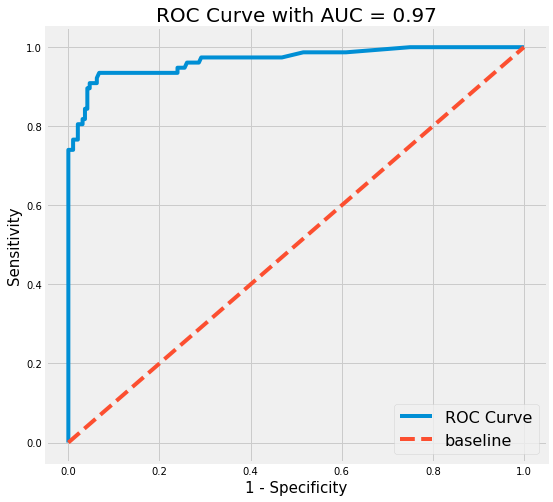

In [296]:
# Create figure.
plt.figure(figsize = (8,8))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),2)}', fontsize=20)
plt.ylabel('Sensitivity', fontsize=15)
plt.xlabel('1 - Specificity', fontsize=15)

# Create legend.
plt.legend(fontsize=16);

In [297]:
cm = confusion_matrix(y_test, logreg_lasso_1.predict(X_test))
cm_df = pd.DataFrame(data=cm, columns=['predicted negative', 'predicted positive'], index=['actual negative', 'actual positive'])
cm_df
# more false negatives than false positives

,predicted negative,predicted positive
actual negative,183,9
actual positive,7,70


## Hyperparameter Selection 
Let's fine tune our hyperparameter of alpha with GridSearchCV to see if we can improve our model further.

In [298]:
log_params = {
    'penalty':["l1", "l2"],
    'C':list(np.linspace(0.01, 5, 10))
}

log_gridsearch = GridSearchCV(LogisticRegression(random_state=8), log_params, cv=5, verbose=1, n_jobs=2)

log_gridsearch = log_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   33.5s finished


In [299]:
print(log_gridsearch.best_score_)
log_gridsearch.best_params_

0.9325270528325907


{'C': 5.0, 'penalty': 'l1'}

In [300]:
log_params = {
    'penalty':["l1"],
    'C':list(np.linspace(0.01, 5, 10))
}

log_gridsearch = GridSearchCV(LogisticRegression(random_state=8), log_params, cv=5, verbose=1, n_jobs=2)

log_gridsearch = log_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   26.1s finished


Text(0.5, 0, '%')

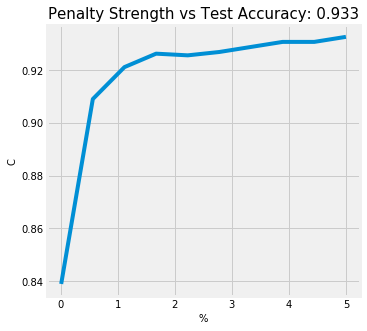

In [301]:
plt.figure(figsize = (5,5))

lst_of_c = [c["C"] for c in pd.DataFrame(log_gridsearch.cv_results_)["params"]]
mean_test_scores = pd.DataFrame(log_gridsearch.cv_results_)["mean_test_score"]
plt.plot(lst_of_c, 
         mean_test_scores)
plt.title(f'Penalty Strength vs Test Accuracy: {round(log_gridsearch.best_score_,3)}', fontsize=15)
plt.ylabel('C', fontsize=10)
plt.xlabel('%', fontsize=10)

In [302]:
print(log_gridsearch.best_score_)
log_gridsearch.best_params_

0.9325270528325907


{'C': 5.0, 'penalty': 'l1'}

## Best Model

In [303]:
# Instantiate Model
logreg_best = LogisticRegression(penalty='l1', C=log_gridsearch.best_params_["C"])

# Fit model.
logreg_best.fit(X_train, y_train)

# Generate prediction values
yhat_train = logreg_lasso_1.predict(X_train)
yhat_test = logreg_lasso_1.predict(X_test)
print("\n")

# Generate predictions/probabilities
yhat_train_proba = logreg_best.predict_proba(X_train)[:,1]
yhat_test_proba = logreg_best.predict_proba(X_test)[:,1]

# Score the model - accuracy
print(f' Logreg train accuracy: {cross_val_score(logreg_best, X_train, y_train, cv=5).mean()}')
print("\n")

print(f' Logreg test accuracy: {cross_val_score(logreg_best, X_test, y_test, cv=5).mean()}')
print("\n")

# Area under the curve
print(f' Area under the curve: {roc_auc_score(y_test, logreg_best.predict_proba(X_test)[:,1])}')



 Logreg train accuracy: 0.9319095069161205




/Users/gc/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 Logreg test accuracy: 0.9187650085763295


 Area under the curve: 0.9662472943722944


/Users/gc/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


|Metric              | Baseline | Logistic Regression, Lasso = 1 | Logistic Regression, Lasso = Optimal |
|--------------------| -------- | ------------------------------ | -------------------------------------|
|Train Accuracy      | 0.915    | 0.921                          | 0.936                                |
|Test Accuracy       | 0.914    | 0.903                          | 0.918                                |
|Area under the curve| 0.940    | 0.961                          | 0.966                                |

In [306]:
pred_15_17 = pd.DataFrame(zip(X_test[["season","team_id"]],yhat_test))
pred_15_17 = pd.DataFrame(
    {"season": X_test["season"],
     "team_id": X_test["team_id"],
     "final_four": y_test,
     "yhat": yhat_test  
    }
)

In [307]:
results = pd.merge(pred_15_17,teams, how="left",on=["season","team_id"]).drop_duplicates().reset_index()
results.sort_values(by="final_four",ascending=False).drop("index",axis=1)
# there were 14 duplicates removed, 269-14=255

,season,team_id,final_four,yhat,team_name,conference_code
254,2015,1196,1,1,Florida,sec
210,2016,1199,1,1,Florida St,acc
34,2015,1246,1,1,Kentucky,sec
223,2016,1364,1,1,Santa Barbara,big_west
222,2016,1330,1,1,Old Dominion,cusa
221,2016,1207,1,1,Georgetown,big_east
220,2016,1373,1,1,Siena,maac
219,2015,1409,1,1,Tulsa,aac
218,2016,1331,1,1,Oral Roberts,summit
217,2016,1402,1,1,Texas St,sun_belt


# Results 

Overall, I was able to improve from the baseline logistic model, by 1.5% in train accuracy, 0% in test accuracy, and 2.6% in ROC curve. What I am impressed about is that the best model via Lasso is able to predict with less variables, while also maintaining interpretability (no wild transformations). 

In summary:

* Win_% is the most important predictor. Although it's strange to see that it has a negative sign, this is probably the case because schools that make to to the final four actually have lower win % than schools who do not make it to the final four because they face tougher competition (57% avg vs 72% avg). This supports the argument that which conference you play for is very important in predictive power. 

* Again, your strongest conferences, are the big_twelve, acc, big_ten. If you play in acc, your likelihood of reaching final four is very low, because you will likely be dominated by the top tier schools in those conferences. 

* In terms of regular season states, 3PM for and against is important, as the game continues to move shooting more threes, as it's been proven to be an effective strategy. 

* Lastly, seed is not to be overlooked as it's a good composite score for a team's strength, capturing a lot of regular season performance. As your seed increases by 1, your likelihood of reaching final four is 0.47x less. This makes sense... a 3 seed only has a ~10% (0.47^3) of making to final four! This is consistent with FiveThirtyEight's forecasts. Purdue, Houston, & Texas Tech had 10-14% of making it to the Final four.

* Similar to the NBA, margin of victory is a predictive variable though with a positive correlation. In the NBA, there is more parity since each team plays one another at least twice in a season, so individual team stats are more important than seed & conference.

My model predicts the probability of a team reaching the final four, primarily based on its regular season data, seed, and conference. I would recommend coaches to develop the three ball ability, as it continues dominate in the NBA and at the college level, and to outperform in the regular season to improve your seeding, to ultimately improve your chances in moving to the final four, through playing weaker opponents. 

Assumptions 
* In this model, there are things that we cannot predict, including injuries, player specific data, draft prospects, travel & time between games (are players are well rested?), coaches track record, momentum of a team firing on all cylinders (last 10 games), given the absence of data.

* In this example, there isn't a penalty on false positives vs false negatives, as wrong is wrong. Predicting a loser who won isn't worse than a winner that lost. There may be implications in gambling, but that's out of scope. 

Research Links
* https://projects.fivethirtyeight.com/2019-march-madness-predictions/ 

##  Next Steps

This was a very fun exploration and may plan to revisit this project in a future blog post.

Ideas:
* Simulating winner between 2 games (or at the very least, the final four), using a Poisson model for pts scored
* Logistic vs Non Parametric (KNN, SVM, random forests)
* Scrap 2018 data, and run model, and add graphs (with SMOTE, 2015->2017 data is obfuscated)
* Feature engineer strength of schedule (they have this on sports reference)
* ELO
* No. of previous appearances in history
* Confidence intervals of predicted probabilities